In [9]:
# DEPS

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

In [10]:
#DATA

# train_dat = 81 cols, 1460 rows
train_dat = pd.read_csv('./train.csv')

# test_dat = 80 cols, 1459 rows
test_dat = pd.read_csv('./test.csv')

pd.options.display.max_columns = 100

In [3]:
# EVALUATION MEASURE

def log_rmse(y, yhat):
    diff_sq = (np.log(y) - np.log(yhat)) ** 2
    return (diff_sq.sum() / y.size) ** 0.5

In [200]:
# MODEL 1
# Predicting price as mean yields log_RMSE of 0.407565460399901 on training set

mean = train_dat.SalePrice.mean()
y = train_dat['SalePrice']
yhat = pd.Series(mean, index=test_dat.index)
error = log_rmse(y, yhat)
print('Error predicting from mean: {}'.format(error))

# Submit the model
test_dat['SalePrice'] = pd.Series(mean, index=test_dat.index)
test_dat[['Id', 'SalePrice']].to_csv('predict_the_mean.csv', index=False)

Error predicting from mean: 0.407565460399901


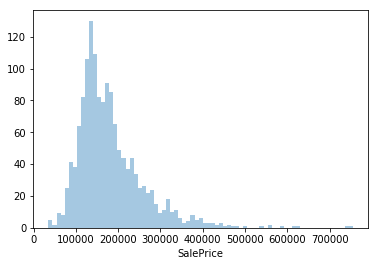

In [201]:
# EDA - what's the distribution of Sale Prices?

sns.distplot(train_dat['SalePrice'],bins=75, kde=False)

In [204]:
# Model 2
# Predicting price as median yields log_RMSE of 0.39994245028678643 on training set

median = train_dat.SalePrice.median()
y = train_dat['SalePrice']
yhat = pd.Series(median, index=test_dat.index)
error = log_rmse(y, yhat)
print('Error predicting from median: {}'.format(error))

# Submit the model
test_dat['SalePrice'] = pd.Series(median, index=test_dat.index)
test_dat[['Id', 'SalePrice']].to_csv('predict_the_median.csv', index=False)

Error predicting from median: 0.39994245028678643


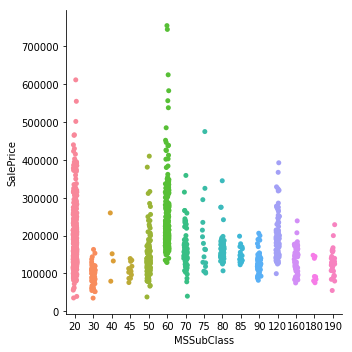

In [203]:
# EDA - Do properties of different types (MSSubClass) have different prices?

sns.catplot(x="MSSubClass", y="SalePrice", data=train_dat)


In [244]:
# Model 3 
# Predicting price as median of the MSSubClass to which the house belongs yields log_RMSE of 0.3323846436857664

groups = train_dat[['MSSubClass', 'SalePrice']].groupby('MSSubClass')
medians = groups.median()
y_hat = train_dat.apply(lambda p: medians.loc[p.loc['MSSubClass']][0], axis=1)
error = log_rmse(train_dat['SalePrice'], y_hat)
print('Error predicting from median of MSSubClass: {}'.format(error))

# Small hiccup - The MSSubClass value `150` is in the test set but not train set
# I can see there's only one property with this value:

print(train_dat[['Id', 'MSSubClass']].groupby('MSSubClass').count())
print(test_dat[['Id', 'MSSubClass']].groupby('MSSubClass').count())

# I'm filling it in with the global median.
medians.loc[150] = train_dat.SalePrice.median()

# Submit the model
y_hat = test_dat.apply(lambda p: medians.loc[p.loc['MSSubClass']][0], axis=1)
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('predict_the_MSSubClass_median.csv', index=False)

Error predicting from median of MSSubClass: 0.3323846436857664


In [29]:
# Curiosity
# If you one hot encode the MSSubClass and do a linear regression (not using any other features)..
# - Q: how would you expect it to perform relative to using the median for each group (by MSSubClass)? 
# - A: almost identically: 0.332125001688164 vs 0.3323846436857664

y = train_dat['SalePrice'].values
y = y.reshape(y.size, -1)
X = pd.get_dummies(train_dat['MSSubClass']).values

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)

print('Error predicting from regression of one hot encoded MSSubClass: {}'.format(error))

Error predicting from regression of one hot encoded MSSubClass: 0.3321325881863102


In [30]:
# EDA - with a view to doing a simple regression
# Which features have values for every entry in train and test?
# Which features are categorical, which are continuous?

train_cols = train_dat.dropna(axis='columns').columns
test_cols = test_dat.dropna(axis='columns').columns
mutual_cols = train_cols.intersection(test_cols)
train_subs = train_dat[mutual_cols]
train_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 46 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
Heating          1460 non-null object
HeatingQC        1460 non-

*Referring to data_description.txt..*

###### CONTINUOUS
- LotArea          
- 1stFlrSF         
- 2ndFlrSF         
- LowQualFinSF     
- GrLivArea        
- FullBath         
- HalfBath         
- BedroomAbvGr     
- KitchenAbvGr     
- TotRmsAbvGrd     
- Fireplaces       
- WoodDeckSF       
- OpenPorchSF      
- EnclosedPorch    
- 3SsnPorch        
- ScreenPorch      
- PoolArea         
- MiscVal          
- *YrSold*
- *YearBuilt*
- *YearRemodAdd*

###### CATEGORICAL
- MSSubClass       
- Street           
- LotShape         
- LandContour      
- LotConfig        
- LandSlope        
- Neighborhood     
- Condition1       
- Condition2       
- BldgType         
- HouseStyle       
- OverallQual      
- OverallCond      
- RoofStyle        
- RoofMatl         
- ExterQual        
- ExterCond        
- Foundation       
- Heating          
- HeatingQC        
- CentralAir       
- PavedDrive       
- MoSold           


In [21]:
# MODEL 4 - Linear Regression with the continuous features which all have values
# Predict price using linear regression with the subset of features that don't require any engineering.

# For this model I will use only the continous variables and I will omit the *year* features; they need more thinking.
# - YrSold
# - YearBuilt
# - YearRemodAdd

col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
             'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
             'PoolArea', 'MiscVal']
X = train_dat[col_names].values
y = train_dat['SalePrice'].values
y = y.reshape(y.size, 1)

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error predicting from linear regression without feature engineering: {}'.format(error))

# Submit the model
y_hat = regr.predict(test_dat[col_names].values)
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('simple_regression.csv', index=False)

Error predicting from linear regression without feature engineering: 0.21708975978691863


In [22]:
# --- UNDER CONSTRUCTION - i.e: Currently broken! ---

# MODEL 5 - Linear Regression with  continuous and categorical features.

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal']
cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

# Problem 1
# ----------
# There are a few features that share values:
# Condition1, Condition2 {Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe}
# OverallQual, OverallCond: {1,2 ... 10}
# CentralAir, PavedDrive: {Y, N}
# Solution:
# I will namespace the new columns (from the one hot encoding) with their original column name
# to avoid collisions.

# Problem 2
# ----------
# (a) There are categorical features in the training set with values that do not appear in the test set.
# (b) There is a categorical feature in the test set with a value that do not appear in the training set.


# Attempted Solution:
# (a) Add these columns to the test_set data with the zeros for values.
# (b) Add these columns to the training_set data with zeros for values.
# There is only one value revlevant to (b): The value of one house's MSSubClass of `150` doesn't appear in training.
# ... DID NOT WORK: predictions are way off on test set: getting negative predicted SalePrices..

# Solving Problem 1
# -----------------

def gen_one_hot(dat):
    one_hots = [pd.get_dummies(dat[n]).add_prefix(n) for n in cat_col_names]
    return pd.concat(one_hots, axis=1) 

# Solving Problem 2
# -----------------

# figure out which one hot cols are only in train or test
one_hot_train = gen_one_hot(train_dat)
one_hot_test = gen_one_hot(test_dat)
train_not_test_cols = one_hot_train.columns.difference(one_hot_test.columns)
test_not_train_cols = one_hot_test.columns.difference(one_hot_train.columns)


# get train fill columns - MSSubClass150
assert(test_not_train_cols.size == 1)
train_fill_col = pd.DataFrame(0, columns=[test_not_train_cols[0]], index=train_dat.index)

# get test fill frame - [Condition2RRAe, Condition2RRAn .. a bunch more]
test_fill_frame = pd.concat([pd.DataFrame(0, columns=[c], index=test_dat.index) for c in train_not_test_cols], axis=1)

# Doing the regression
# --------------------

cont_cols = train_dat[cont_col_names]
X = pd.concat([gen_one_hot(train_dat), cont_cols, train_fill_col ], axis=1)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error predicting from linear regression with one hot categorical variables: {}'.format(error))

# Test
cont_cols = test_dat[cont_col_names]
X = pd.concat([gen_one_hot(test_dat), cont_cols, test_fill_frame], axis=1)
y_hat = regr.predict(X)
y_hat


# submit the model
#test_dat['SalePrice'] = y_hat
#test_dat[['Id', 'SalePrice']].to_csv('simple_regression.csv', index=False)


Error predicting from linear regression with one hot categorical variables: 0.13316009736002396


array([ 1.72742603e+07, -3.58574914e+08,  1.88310113e+07, ...,
        2.81331805e+07, -5.93790655e+06,  1.30878397e+07])